In [2]:
from fastai.vision.all import *

In [3]:
import torch
torch.backends.mps.is_available() # metal GPU acceleration

True

In [4]:
FPS = 3
H, W, C = 512, 512, 3
NUM_FRAMES = 30 # 10s

In [5]:
dls = ImageDataLoaders.from_folder(Path("frames/labeled_data"), valid_pct=0.2, item_tfms=Resize(224), device="mps")

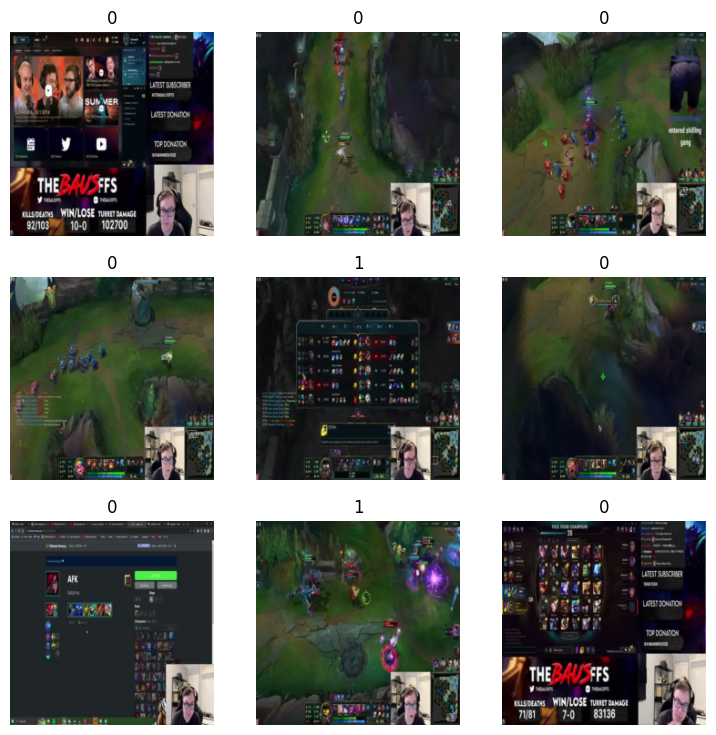

In [6]:
dls.show_batch()

In [10]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, F1Score()])

SuggestedLRs(valley=0.0014454397605732083)

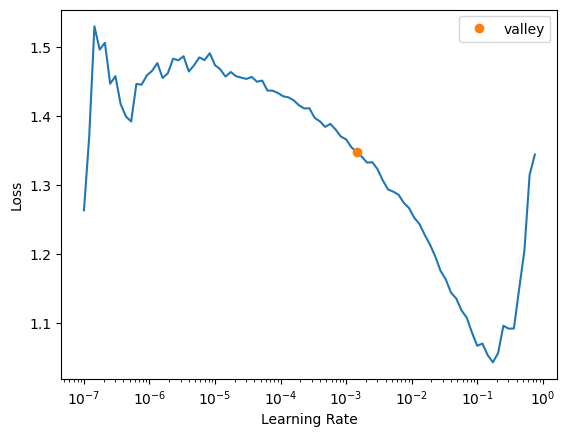

In [11]:
learn.lr_find()

In [14]:
learn.fine_tune(1, 0.0014454397605732083)

epoch,train_loss,valid_loss,error_rate,f1_score,time


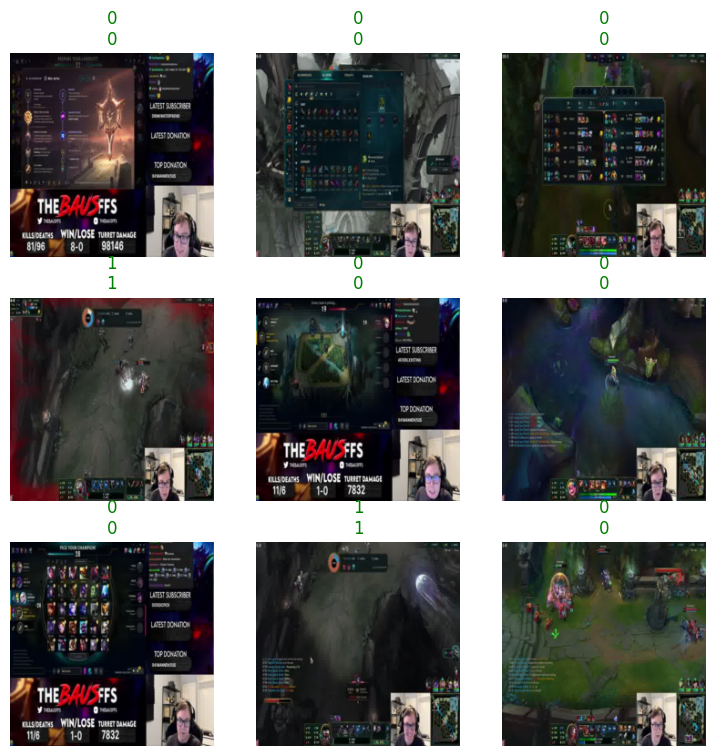

In [15]:
learn.show_results()

In [ ]:
learn.save("fast_ai_resnet34")

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

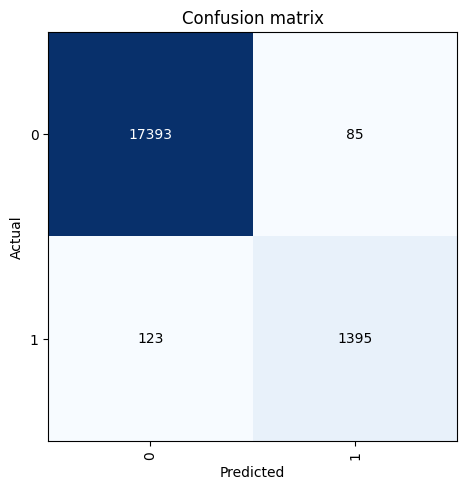

In [20]:
interp.plot_confusion_matrix()

In [21]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17478
           1       0.94      0.92      0.93      1518

    accuracy                           0.99     18996
   macro avg       0.97      0.96      0.96     18996
weighted avg       0.99      0.99      0.99     18996



In [22]:
interp.most_confused()

[('1', '0', 123), ('0', '1', 85)]

In [44]:
next(learn.model.parameters()).device # MPS = Mac Metal GPU

device(type='mps', index=0)

# Add Chunking

Because we don't want too much leakage!

In [ ]:
from fastai.vision.all import *
import random

# Define the duration of each chunk in seconds
chunk_duration_s = 10
chunk_duration = 3 * chunk_duration_s

# Define the path to the video frames directory
frames_directory = 'frames/labeled_data/'

# Get the image files from the directory
image_files = get_image_files(frames_directory)

# Define a function to create chunks
def create_chunks(files, chunk_duration):
    chunks = []
    chunk_start = 0
    while chunk_start + chunk_duration <= len(files):
        chunks.append(files[chunk_start:chunk_start + chunk_duration])
        chunk_start += chunk_duration
    return chunks

# Create chunks from the image files
chunks = create_chunks(image_files, chunk_duration)

# Randomly shuffle the chunks
random.seed(42)
random.shuffle(chunks)

# Split the chunks into training and validation sets
train_size = int(0.8 * len(chunks))
train_chunks = chunks[:train_size]
val_chunks = chunks[train_size:]

# Define the necessary transformations
def get_x(chunk):
    # Concatenate the images in the chunk horizontally
    return torch.cat([Image.open(file) for file in chunk], dim=2)

def get_y(chunk):
    # Return any labels associated with the chunk
    return None

# Create the DataLoaders for training and validation
train_dataloader = DataBlock(blocks=(ImageBlock, CategoryBlock),
                             get_x=get_x,
                             get_y=get_y,
                             splitter=IndexSplitter(range(len(train_chunks))),
                             item_tfms=Resize((224, 224)),
                             batch_tfms=aug_transforms()).dataloaders(chunks, bs=32)

val_dataloader = DataBlock(blocks=(ImageBlock, CategoryBlock),
                           get_x=get_x,
                           get_y=get_y,
                           splitter=IndexSplitter(range(len(train_chunks), len(chunks))),
                           item_tfms=Resize((224, 224))).dataloaders(val_chunks, bs=32)


In [ ]:
# GPT 4
from fastai.vision.all import *
import os
import random

# Define path
path = Path('path_to_your_data')

# Define get_x and get_y functions
get_x = lambda x: path/x
get_y = lambda x: parent_label(x)

# Create list of image paths
files = get_image_files(path)

# Sort the list of files
files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

# Create chunks of files
chunk_size = 10
chunks = [files[i:i + chunk_size] for i in range(0, len(files), chunk_size)]

# Shuffle the chunks
random.shuffle(chunks)

# Flatten the list of chunks
files = [item for sublist in chunks for item in sublist]

# Create a DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=lambda x: files, 
    get_x=get_x, 
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2),  # adjust as necessary
    item_tfms=Resize(460),  # adjust as necessary
    batch_tfms=aug_transforms(size=224)  # adjust as necessary
)

# Create a DataLoader
dls = dblock.dataloaders(path)

# Create a model
learn = cnn_learner(dls, resnet34, metrics=accuracy)  # adjust as necessary

# Find learning rate
learn.lr_find()

# Train the model
learn.fit_one_cycle(4, lr_max=1e-2)  # adjust as necessary

# Save the model
learn.save('model')